
# **COMP9414 Artificial Intelligence**
## Assignment 1: Constraint Satisfaction Search

@Authors: **Wayne Wobcke, Alfred Krzywicki, Stefano Mezza**

**Due Date:** Week 5, Friday, October 17, 5.00pm

### Objective

This assignment concerns developing optimal solutions to a scheduling problem inspired by the scenario of a manufacturing plant that has to fulfil multiple customer orders with varying deadlines, but where there may be constraints on tasks and on relationships between tasks. Any number of tasks can be scheduled at the same time, but it is possible that some tasks cannot be finished before their deadline. A task finishing late is acceptable, however incurs a cost, which for this assignment is a simple (dollar) amount per hour that the task is late.

A *fuzzy scheduling* problem in this scenario is simplified by ignoring customer orders and having just one machine and a number of *tasks*, each with a fixed duration in hours. Each task must start and finish on the same day, within working hours (9am to 5pm). In addition, there can be *constraints*, both on single tasks and between two tasks. One type of constraint is that a task can have a deadline, which can be “hard” (the deadline must be met in any valid schedule) or “soft” (the task may be finished late &ndash; though still at or before 5pm &ndash; but with a “cost” per hour for missing the deadline). The aim is to develop an overall schedule for all the tasks (in a single week) that minimizes the total cost of all the tasks that finish late, provided that all the hard constraints on tasks are satisfied.

More technically, this assignment is an example of a *constraint optimization problem* (or *constrained optimization problem*), a problem that has constraints like a standard Constraint Satisfaction Problem (CSP), but also a *cost* associated with each solution. For this assignment, we will use a *greedy* algorithm to find optimal solutions to fuzzy scheduling problems that are specified as text strings. However, unlike the greedy search algorithm described in the lectures on search, this greedy algorithm has the property that it is guaranteed to find an optimal solution for any problem (if a solution exists).

The assignment will use the AIPython code of Poole & Mackworth. You are given code to translate fuzzy scheduling problems specified as text strings into CSPs with a cost, and you are given code for several constraint solving algorithms &ndash; based on domain splitting and arc consistency, and based on depth-first search. The assignment will be to implement some missing procedures and to analyse the performance of the constraint solving methods, both analytically and experimentally.

### Submission Instructions

- This is an individual assignment.

- Write your answers in **this** notebook and submit **this** notebook on Moodle under **Assignment 1**.

- Name your submission ``<zid>-<firstname>-<lastname>.ipynb`` where ``<firstname>-<lastname>`` is your **real** (not Moodle) name.

- Make sure you set up AIPython (as done below) so the code can be run on either CSE machines or a marker's own machine.

- Do not submit any AIPython code. Hence do not change any AIPython code to make your code run.

- Make sure your notebook runs cleanly (restart the kernel, clear all outputs and run each cell to check).

- After checking that your notebook runs cleanly, run all cells and submit the notebook **with** the outputs included (do not submit the empty version).

- Make sure images (for plots/graphs) are **included** in the notebook you submit (sometimes images are saved on your machine but are not in the notebook).

- Do not modify the existing code in this notebook except to answer the questions. Marks will be given as and where indicated.

- If you want to submit additional code (e.g. for generating plots), add that at the end of the notebook.

- **Important: Do not distribute any of this code on the Internet. This includes ChatGPT. Do not put this assignment into any LLM.**

### Late Penalties

Standard UNSW late penalties apply (5% of the value of the assignment per day or part day late).

**Note:** Unlike the CSE systems, there is no grace period on Moodle. The due date and time is 5pm **precisely** on Friday October 17.

**Important: You can submit as many times as you want before the due date, but if you do submit before the due date, you cannot submit on Moodle after the due date. If you do not submit before the due date, you can submit on Moodle after the due date.**

### Plagiarism

Remember that ALL work submitted for this assignment must be your own work and no sharing or copying of code or answers is allowed. You may discuss the assignment with other students but must not collaborate on developing answers to the questions. You may use code from the Internet only with suitable attribution of the source. You may not use ChatGPT or any similar software to generate any part of your explanations, evaluations or code. Do not use public code repositories on sites such as github or file sharing sites such as Google Drive to save any part of your work &ndash; make sure your code repository or cloud storage is private and do not share any links. This also applies after you have finished the course, as we do not want next year’s students accessing your solution, and plagiarism penalties can still apply after the course has finished.

All submitted assignments will be run through plagiarism detection software to detect similarities to other submissions, including from past years. You should **carefully** read the UNSW policy on academic integrity and plagiarism (linked from the course web page), noting, in particular, that collusion (working together on an assignment, or sharing parts of assignment solutions) is a form of plagiarism.

Finally, do not use any contract cheating “academies” or online “tutoring” services. This counts as serious misconduct with heavy penalties up to automatic failure of the course with 0 marks, and expulsion from the university for repeat offenders.

### Fuzzy Scheduling

A CSP for this assignment is a set of variables representing tasks, binary constraints on pairs of tasks, and unary constraints (hard or soft) on tasks. The domains are all the working hours in one week, and a task duration is in hours. Days are represented (in the input and output) as strings ‘mon’, ‘tue’, ‘wed’, ‘thu’ and ‘fri’, and times are represented as strings ‘9am’, ‘10am’, ‘11am’, ‘12pm’, ‘1pm’, ‘2pm’, ‘3pm’, ‘4pm’ and ‘5pm’. The only possible values for the start and end times of a task are combinations of a day and times, e.g. ‘mon 9am’. Each task name is a string (with no spaces), and the only soft constraints are the soft deadline constraints.

There are three types of constraint:

- **Binary Constraints:** These specify a hard requirement for the relationship between two tasks.
- **Hard Domain Constraints:** These specify hard requirements for the tasks themselves.
- **Soft Deadline Constraints:** These constraints specify that a task may finish late, but with a given cost.

Each soft constraint has a function defining the *cost* associated with violating the preference, that the constraint solver must minimize, while respecting all the hard constraints. The *cost* of a solution is simply the sum of the costs for the soft constraints that the solution violates (and is always a non-negative integer).

This is the list of possible constraints for a fuzzy scheduling problem (comments below are for explanation and do **not** appear in the input specification; however, the code we supply *should* work with comments that take up a full line): 

```
# binary constraints
constraint, ⟨t1⟩ before ⟨t2⟩           # t1 ends when or before t2 starts
constraint, ⟨t1⟩ after ⟨t2⟩            # t1 starts after or when t2 ends
constraint, ⟨t1⟩ same-day ⟨t2⟩         # t1 and t2 are scheduled on the same day
constraint, ⟨t1⟩ starts-at ⟨t2⟩        # t1 starts exactly when t2 ends

# hard domain constraints
domain, ⟨t⟩, ⟨day⟩, hard                                    # t starts on given day at any time
domain, ⟨t⟩, ⟨time⟩, hard                                   # t starts at given time on any day
domain, ⟨t⟩, starts-before ⟨day⟩ ⟨time⟩, hard               # t starts at or before day, time
domain, ⟨t⟩, starts-after ⟨day⟩ ⟨time⟩, hard                # t starts at or after day, time
domain, ⟨t⟩, ends-before ⟨day⟩ ⟨time⟩, hard                 # t ends at or before day, time
domain, ⟨t⟩, ends-after ⟨day⟩ ⟨time⟩, hard                  # t starts at or after day, time
domain, ⟨t⟩, starts-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard  # day-time range for start time; includes day1, time1 and day2, time2
domain, ⟨t⟩, ends-in ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard    # day-time range for end time; includes day1, time1 and day2, time2
domain, ⟨t⟩, starts-before ⟨time⟩, hard                     # t starts at or before time on any day
domain, ⟨t⟩, ends-before ⟨time⟩, hard                       # t ends at or before time on any day
domain, ⟨t⟩, starts-after ⟨time⟩, hard                      # t starts at or after time on any day
domain, ⟨t⟩, ends-after ⟨time⟩, hard                        # t ends at or after time on any day

# soft deadline constraint
domain, ⟨t⟩, ends-by ⟨day⟩ ⟨time⟩ ⟨cost⟩, soft          # cost per hour of missing deadline
```

The input specification will consist of several “blocks”, listing the tasks, binary constraints, hard unary constraints and soft deadline constraints for the given problem. A “declaration” of each task will be included before it is used in a constraint. A sample input specification is as follows. Comments are for explanation and do **not** have to be included in the input.

```
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadline constraints
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
```

## Preparation

### 1. Set up AIPython

You will need AIPython for this assignment. To find the aipython files, the aipython directory has to be added to the Python path.

Do this temporarily, as done here, so we can find AIPython and run your code (you will not submit any AIPython code).

You can add either the full path (using `os.path.abspath`), or as in the code below, the relative path.

In [1]:
import sys
sys.path.append('aipython') # change to your directory
sys.path # check that aipython is now on the path

['D:\\comp9414',
 'D:\\anaconda\\python311.zip',
 'D:\\anaconda\\DLLs',
 'D:\\anaconda\\Lib',
 'D:\\anaconda',
 '',
 'C:\\Users\\zeche\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'D:\\anaconda\\Lib\\site-packages',
 'D:\\anaconda\\Lib\\site-packages\\win32',
 'D:\\anaconda\\Lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\Lib\\site-packages\\Pythonwin',
 'aipython']

### 2. Representation of Day Times

Input and output are day time strings such as 'mon 10am' or a range of day time strings such as 'mon 10am-mon 4pm'.

The CSP will represent these as integer hour numbers in the week, ranging from 0 to 39.

The following code handles the conversion between day time strings and hour numbers.

In [2]:
# -*- coding: utf-8 -*-
    
""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""
class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        value = None
        value_type = None
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0].strip()
            if str1 in self.time_names: # this is a time
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            else:
                value = self.day_names.index(str1) # this is a day
                value_type = 'day_number'
            # if not day or time, throw an exception
        else:
            value = self.day_names.index(day_time_list[0].strip())*self.num_hours_in_day \
                + self.time_names.index(day_time_list[1].strip())
            value_type = 'week_hour_number'
        return (value_type, value)

    def string_to_number_set(self, day_time_list_str):
        """ convert a list of day-times or ranges 'Mon 9am, Tue 9am-Tue 4pm' into a list of integer hours in the week
            e.g. 'mon 9am-1pm, mon 4pm' -> [0,1,2,3,4,7]
        """
        number_set = set()
        type1 = None
        for str1 in day_time_list_str.lower().split(','):
            if str1.find('-') > 0:
                # day time range
                type1, v1 = self.string_to_week_hour_number(str1.split('-')[0].strip())
                type2, v2 = self.string_to_week_hour_number(str1.split('-')[1].strip())
                if type1 != type2: return None # error, types in range spec are different
                number_set.update({n for n in range(v1, v2+1)})
            else:
                # single day time
                type2, value2 = self.string_to_week_hour_number(str1)
                if type1 != None and type1 != type2: return None # error: type in list is inconsistent
                type1 = type2
                number_set.update({value2})
        return (type1, number_set)
    
    # convert integer hour in week to day time string
    def week_hour_number_to_day_time(self, week_hour_number):
        hour = self.day_hour_number(week_hour_number)
        day = self.day_number(week_hour_number)
        return self.day_names[day]+' '+self.time_names[hour]
    
    # convert integer hour in week to integer day and integer time in day
    def hour_day_split(self, week_hour_number):
        return (self.day_hour_number(week_hour_number), self.day_number(week_hour_number))
    
    # convert integer hour in week to integer day in week
    def day_number(self, week_hour_number):
        return int(week_hour_number / self.num_hours_in_day)
    
    # convert integer hour in week to integer time in day
    def day_hour_number(self, week_hour_number):
        return week_hour_number % self.num_hours_in_day
    
    def __repr__(self):
        day_hour_number = self.week_hour_number % self.num_hours_in_day
        day_number = int(self.week_hour_number / self.num_hours_in_day)
        return self.day_names[day_number]+' '+self.time_names[day_hour_number]

### 3. Constraint Satisfaction Problems with Costs over Tasks with Durations

Since AI Python does not provide the CSP class with an explicit cost, we implement our own class that extends `CSP`.

We also store the cost functions and the durations of all tasks explicitly in the CSP.

The durations of the tasks are used in the `hold` function to evaluate constraints.

In [3]:
from cspProblem import CSP, Constraint

class Task_Constraint(Constraint):
    """A Task_Constraint consists of
    * scope: a tuple of variables
    * spec: text description of the constraint used in debugging
    * condition: a function that can applied to a tuple of values for the variables
    * durations: durations of all tasks
    * func_key: index to the function used to evaluate the constraint
    """
    def __init__(self, scope, spec, condition, durations, func_key):
        super().__init__(scope, condition, spec)
        self.scope = scope
        self.condition = condition
        self.durations = durations
        self.func_key = func_key

    def holds(self, assignment):
   
        if len(self.scope) != 2:
            return True

        var0 = self.scope[0]
        var1 = self.scope[1]

        has0 = (var0 in assignment)
        has1 = (var1 in assignment)
        if (has0 is False) or (has1 is False):
            return True

        s0 = assignment[var0]           
        s1 = assignment[var1]
        d0 = self.durations[var0]       
        d1 = self.durations[var1]

        if self.func_key == 'before':
            left = s0 + d0            
            right = s1             
            return self.condition(left, right)

        elif self.func_key == 'after':
            left = s0               
            right = s1 + d1            
            return self.condition(left, right)

        elif self.func_key == 'starts-at':
            left = s0                     
            right = s1 + d1                
            return self.condition(left, right)

        elif self.func_key == 'same-day':
            day0 = s0 // 8
            day1 = s1 // 8
            if day0 == day1:
                return True
            else:
                return False

        elif self.func_key == 'non-overlap':
            end0 = s0 + d0
            end1 = s1 + d1
            left_ok = (end0 <= s1)
            right_ok = (end1 <= s0)
            if left_ok or right_ok:
                return True
            else:
                return False

        return self.condition(s0, s1)

class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var (task name) -> list of cost functions (not used in this simple version). """
    def __init__(self, domains, durations, constraints, cost_functions, soft_day_time, soft_costs):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.durations = durations
        self.cost_functions = cost_functions
        self.soft_day_time = soft_day_time
        self.soft_costs = soft_costs
        self.cost = self.calculate_cost()

    def calculate_cost(self):
        dt = Day_Time()
        total = 0
        
        for v in self.soft_day_time:
            dom = self.domains.get(v, [])
            if not dom or len(dom) == 0:
                return 10**9  
            
            raw = self.soft_day_time[v] 
            if isinstance(raw, int):
                deadline = raw
            elif isinstance(raw, str):
                k = dt.string_to_week_hour_number(raw)
                deadline = k[1] if isinstance(k, tuple) and len(k) >= 2 else None
            else:
                deadline = None

            pen = self.soft_costs.get(v, 0)
            dur = self.durations[v]
            
            best_cost = float('inf')
            for start_time in dom:
                end_time = start_time + dur
                
                if deadline is None:
                    cost = 0
                else:
                    late_hours = max(0, end_time - deadline)
                    cost = late_hours * pen
                
                best_cost = min(best_cost, cost)
            
            total += best_cost
        
        return total

    def __repr__(self):
        return "CSP_with_Cost(" + str(list(self.domains.keys())) + ':' + str(self.cost) + ")"


This formulates a solver for a CSP with cost as a search problem, using domain splitting with arc consistency to define the successors of a node.

In [4]:
from cspConsistency import Con_solver, select, partition_domain 
from searchProblem import Arc, Search_problem
from operator import eq, le, ge

# rewrites rather than extends Search_with_AC_from_CSP
class Search_with_AC_from_Cost_CSP(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        self.durations = csp.durations
        self.soft_day_time = csp.soft_day_time
        self.soft_costs = csp.soft_costs
        csp.domains = self.domains # after arc consistency
        self.csp = csp

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return CSP_with_Cost(self.domains, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)

    def neighbors(self, node):
        """returns the neighboring nodes of node.
        """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            dom1, dom2 = partition_domain(node.domains[var])
            self.display(2, "Splitting", var, "into", dom1, "and", dom2)
            to_do = self.cons.new_to_do(var, None)
            for dom in [dom1,dom2]:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs    
    
    def heuristic(self, n):
        return n.cost

### 4. Fuzzy Scheduling Constraint Satisfaction Problems

The following code sets up a CSP problem from a given specification.

Hard (unary) domain constraints are applied to reduce the domains of the variables before the constraint solver runs.

In [5]:
# domain specific CSP builder for week schedule
class CSP_builder():
    # list of text lines without comments and empty lines
    _, default_domain = Day_Time().string_to_number_set('mon 9am-fri 4pm') # should be 0,...,39
    
    # hard unary constraints: domain is a list of values, params is a single value
    # starts-before, ends-before (for starts-before duration should be 0)
    # vals in domain are actual task start/end date/time, so must be val <= whatever is in params
    def apply_before(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 > param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_after(self, param_type, params, duration, domain):
        domain_orig = domain.copy()
        param_val = params.pop()
        for val in domain_orig: # val is week_hour_number
            val1 = val + duration
            h, d = Day_Time().hour_day_split(val1)
            if param_type == 'hour_number' and h < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val1 < param_val:
                if val in domain: domain.remove(val)
        return domain
    
    # day time range only
    # includes starts-in, ends-in
    # duration is 0 for starts-in, task duration for ends-in
    def apply_in(self, params, duration, domain):
        domain_orig = domain.copy()
        for val in domain_orig: # val is week_hour_number
            # task must be within range
            if val in domain and val+duration not in params:
                domain.remove(val)
        return domain
    
    # task must start at day/time    
    def apply_at(self, param_type, param,domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and param != h:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and param != d:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and param != val:
                if val in domain: domain.remove(val)
        return domain

    # soft deadline constraints: return cost to break constraint
    # ends-by implementation: domain_dt is the day, hour from the domain
    # constr_dt is the soft const spec, dur is the duration of task
    # soft_cost is the unit cost of completion delay
    # so if the tasks starts on domain_dt, it ends on domain_dt+dur
    """
    <t> ends-by <day> <time>, both must be specified
    delay = day_hour(T2) – day_hour(T1) + 24*(D2 - D1), 
    where day_hour(9am) = 0, day_hour(5pm) = 7
    """
    def ends_by(self, domain_dt, constr_dt_str, dur, soft_cost):
        param_type,params = Day_Time().string_to_number_set(constr_dt_str)
        param_val = params.pop()
        dom_h, dom_d = Day_Time().hour_day_split(domain_dt+dur)
        if param_type == 'week_hour_number':
            con_h, con_d = Day_Time().hour_day_split(param_val)
            return 0 if domain_dt + dur <= param_val else soft_cost*(dom_h - con_h + 24*(dom_d - con_d))
        else:
           return None # not good, must be day and time
    
    def no_cost(self, day ,hour):
        return 0
    
    # hard binary constraint, the rest are implemented as gt, lt, eq
    def same_day(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return d1 == d2
        
    # domain is a list of values
    def apply_hard_constraint(self, domain, duration, spec):
        tokens = func_key = spec.split(' ')
        if len(tokens) > 1:
           func_key = spec.split(' ')[0].strip()
           param_type, params = Day_Time().string_to_number_set(spec[len(func_key):])
           if func_key == 'starts-before':
              # duration is 0 for starts before, since we do not modify the time
              return self.apply_before(param_type, params, 0, domain)
           if func_key == 'ends-before':
               return self.apply_before(param_type, params, duration, domain)
           if func_key == 'starts-after':
              return self.apply_after(param_type,params,0,domain)
           if func_key == 'ends-after':
              return self.apply_after(param_type, params, duration, domain)
           if func_key == 'starts-in':
               return self.apply_in(params, 0, domain)
           if func_key == 'ends-in':
               return self.apply_in(params, duration, domain)
        else:
           # here we have task day or time, it has no func key so we need to parse again
           param_type,params = Day_Time().string_to_week_hour_number(spec)
           return self.apply_at(param_type, params, domain)
           
    def get_cost_function(self, spec):
        func_dict = {'ends-by':self.ends_by, 'no-cost':self.no_cost}
        return [func_dict[spec]]
    
    # spec is the text of a constraint, e.g. 't1 before t2'
    # durations are durations of all tasks
    def get_binary_constraint(self, spec, durations):
        tokens = spec.strip().split(' ')
        if len(tokens) != 3: return None # error in spec
        # task1 relation task2
        fun_dict = {'before':le, 'after':ge, 'starts-at':eq, 'same-day':self.same_day}
        return Task_Constraint((tokens[0].strip(), tokens[2].strip()), spec, fun_dict[tokens[1].strip()], durations, tokens[1].strip())
    
    def get_CSP_with_Cost(self, input_lines):
        # Note: It would be more elegant to make task a class but AIpython is not designed for this:
        # CSP_with_Cost inherits from CSP, which takes domains and constraints from all tasks instead of tasks themselves
        domains = dict()
        constraints = []
        cost_functions = dict()
        durations = dict() # durations of tasks
        soft_day_time = dict() # day time specs of soft constraints
        soft_costs = dict() # costs of soft constraints
        
        for input_line in input_lines:
            func_spec = None
            input_line_tokens = input_line.strip().split(',')
            if len(input_line_tokens) != 2: 
                return None # must have number of tokens = 2
            line_token1 = input_line_tokens[0].strip()
            line_token2 = input_line_tokens[1].strip()
            if line_token1 == 'task':
                tokens = line_token2.split(' ')
                if len(tokens) != 2: 
                    return None # must have number of tokens = 3
                key = tokens[0].strip()
                # check the duration and save it
                duration = int(tokens[1].strip())
                if duration > Day_Time().num_hours_in_day: 
                    return None
                durations[key] = duration
                # set zero cost function for this task as default, may add real cost later
                cost_functions[key] = self.get_cost_function('no-cost')
                soft_costs[key] = '0'
                soft_day_time[key] = 'fri 5pm'
                # restrict domain to times that are within allowed range
                # that is start 9-5, start+duration in 9-5
                domains[key] = {x for x in self.default_domain \
                                if Day_Time().day_number(x+duration) \
                                == Day_Time().day_number(x)}
            elif line_token1 == 'domain':
                tokens = line_token2.split(' ')
                if len(tokens) < 2: 
                    return None # must have number of tokens >= 2
                key = tokens[0].strip()
                # if soft constraint, it is handled differently from hard constraints
                if tokens[1].strip() == 'ends-by':
                    # need to retain day time and cost from the line
                    # must have task, 'end-by', day, time, cost
                    # or task, 'end-by', day, cost
                    # or task, 'end-by', time, cost
                    if len(tokens) != 5: 
                        return None 
                    # get the rest of the line after 'ends-by'
                    soft_costs[key] = int(tokens[len(tokens)-1].strip()) # last token is always cost
                    # pass the day time string to avoid passing param_type
                    day_time_str = tokens[2] + ' ' + tokens[3]
                    soft_day_time[key] = day_time_str
                    cost_functions[key] = self.get_cost_function(tokens[1].strip())
                else:
                    # the rest of domain spec, after key, are hard unary domain constraints
                    # func spec has day time, we also need duration
                    dur = durations[key]
                    func_spec = line_token2[len(key):].strip()
                    domains[key] = self.apply_hard_constraint(domains[key], dur, func_spec)       
            elif line_token1 == 'constraint': # all binary constraints
                constraints.append(self.get_binary_constraint(line_token2, durations))
            else:
                return None
            
        return CSP_with_Cost(domains, durations, constraints, cost_functions, soft_day_time, soft_costs)
    
def create_CSP_from_spec(spec: str):
    input_lines = list()    
    spec = spec.split('\n')
    # strip comments
    for input_line in spec:
        input_line = input_line.split('#')
        if len(input_line[0]) > 0:
            input_lines.append(input_line[0])
            print(input_line[0])
    # construct initial CSP problem
    csp = CSP_builder()
    csp_problem = csp.get_CSP_with_Cost(input_lines)
    return csp_problem

### 5. Greedy Search Constraint Solver using Domain Splitting and Arc Consistency

Create a GreedySearcher to search over the CSP.

The *cost* function for CSP nodes is used as the heuristic, but is actually a direct estimate of the total path cost function *f* used in A* Search.

In [6]:
from searchGeneric import AStarSearcher

class GreedySearcher(AStarSearcher):
    """ returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """
    def add_to_frontier(self, path):
        """ add path to the frontier with the appropriate cost """
        # value = path.cost + self.problem.heuristic(path.end()) -- A* definition
        value = path.end().cost
        self.frontier.add(path, value)      

Run the GreedySearcher on the CSP derived from the sample input.

**Note: The solution cost will always be 0 (which is wrong for the sample input) until you write the cost function in the cell above.**

In [7]:
# Sample problem specification

sample_spec = """
# two tasks with two binary constraints and soft deadlines
task, t1 3
task, t2 4
# two binary constraints
constraint, t1 before t2
constraint, t1 same-day t2
# domain constraint
domain, t2 mon
# soft deadlines
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
"""

In [8]:
# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 0

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
t1: mon 9am
t2: mon 12pm
cost: 10


### 6. Depth-First Search Constraint Solver

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We need to modify this code to make it compatible with the arc consistency solver.

Run the solver by calling `dfs_solve1` (first solution) or `dfs_solve_all` (all solutions).

In [9]:
num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
    """
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:])

def dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    return list(dfs_solver(csp.constraints, csp.domains, {}, var_order))

def dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run the Depth-First Solver on the sample problem.

**Note: Again there are no costs calculated.**

In [10]:
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) # set display to True to see nodes expanded

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
Nodes expanded to reach solution: 5
t1: mon 9am
t2: mon 12pm


### 7. Depth-First Search Constraint Solver using Forward Checking with MRV Heuristic

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We redefine the `dfs_solver` methods to implement the MRV (Minimum Remaining Values) heuristic using forward checking.

Because the AIPython code is designed to manipulate domain sets, we also need to redefine `can_evaluate` to handle partial assignments.

In [11]:
num_expanded = 0
display = False

def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order is a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        any_value = list(domains[rem_var])[0]
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: any_value})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run this solver on the sample problem.

**Note: Again there are no costs calculated.**

In [12]:
def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])

# call the Depth-First MRV Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_mrv_dfs_solver(csp_problem) # set display to True to see nodes expanded

task, t1 3
task, t2 4
constraint, t1 before t2
constraint, t1 same-day t2
domain, t2 mon
domain, t1 ends-by mon 3pm 10
domain, t2 ends-by mon 3pm 10
Nodes expanded to reach solution: 5
t2: mon 12pm
t1: mon 9am


## Assignment

**Name:**

**zID:**

### Question 1 (4 marks)

Consider the search spaces for the fuzzy scheduling CSP solvers &ndash; domain splitting with arc consistency and the DFS solver (without forward checking).

- Describe the search spaces in terms of start state, successor functions and goal state(s) (1 mark)
- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)
- What is the worst case time and space complexity of the two search algorithms? (1 mark)
- Give one example of a fuzzy scheduling problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

For the second and third part-questions, give the answer in a general form in terms of fuzzy scheduling CSP size parameters.

__Answers for Question 1__

Write the answers here.
1,For domain splitting with arc consistency, the start state is a CSP where every variable still have many possible start time. which All hard constraints already used to cut domain, and AC is applied. The successor function choose one variable that still has more than one value and split it into two parts. Then each child run AC again to reduce domain. 
The goal state is when every task only has one time left. DFS start from empty, choose one task, try each time value, and keep going until all are placed and no rule is broken.

2, Let n be the number of tasks and d the average domain size. For domain splitting, branching factor ≈ 2 because we split into two. Maximum depth ≈ Σ log₂(|Dᵢ|). therefore, branching factor ≈ d, depth = n. 

3, Domain splitting + AC run arc consistency on each node. The AC cost is about O(e × d³). So worst case time is O(e × d³ × dⁿ). Space ≈ O(n × d) because store domains for each variable. therefore, DFS without forward checking try every combination, time O(e × dⁿ), space O(n).

4, when we have many tasks like t1 before t2 before t3 and same-day constraints. Arc consistency can quickly propagate the relations and cut a lot of values.This is because most impossible combinations removed before search even start,it check constraint only after assignment complete. Thus, DFS don’t do this propagation, so it will try many wrong orders and waste time backtracking. 

### Question 2 (5 marks)

Define the *cost* function for a fuzzy scheduling CSP (i.e. a node in the search space for domain splitting and arc consistency) as the total cost of the soft deadline constraints violated for all of the variables, assuming that each variable is assigned one of the best possible values from its domain, where a “best” value for a variable *v* is one that has the lowest cost to violate the soft deadline constraint (if any) for that variable *v*.

- Implement the cost function in the indicated cell and place a copy of the code below (3 marks)
- What is its computational complexity (give a general form in terms of fuzzy scheduling CSP size parameters)? (1 mark)
- Show that the cost function *f* never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

In [20]:
def calculate_cost(self):
    dt = Day_Time()
    total = 0

    for v in self.soft_day_time:
        dom = self.domains.get(v, [])
        if not dom or len(dom) == 0:
            return 10**9 
        
        raw = self.soft_day_time[v] 
        if isinstance(raw, int):
            deadline = raw
        elif isinstance(raw, str):
            k = dt.string_to_week_hour_number(raw)
            deadline = k[1] if isinstance(k, tuple) and len(k) >= 2 else None
        else:
            deadline = None
        
        pen = self.soft_costs.get(v, 0)
        dur = self.durations[v]
        
        best_cost = float('inf')
        for start_time in dom:
            end_time = start_time + dur
            
            if deadline is None:
                cost = 0
            else:
                late_hours = max(0, end_time - deadline)
                cost = late_hours * pen
            
            best_cost = min(best_cost, cost)
        
        total += best_cost
    
    return total

__Answers for Question 2__

Write the other answers here
1，The cost function measure total penalty from all soft deadlines. For each task, it calculate how late it finish compared to its deadline and multiply by the penalty rate.
If one task has empty domain, that means it cannot be done, so it return a very big cost.
This is because we want to punish impossible states, therefore the number show how bad the schedule is.

2.
For n tasks and average domain size d, the cost function only check each task once.
Finding the smallest value in one domain take O(d).
Therefore total time is O(n·d).

3.
Let the cost of a node be the sum, for all variables, of the minimum penalty achievable within their current domains.
When a domain is split during search, the new domain is always a subset of the old one.
Since taking the minimum over a smaller set cannot produce a smaller value, the local cost for each variable never decreases.
Because the evaluation function f(n) = cost(n) never decreases, the greedy search always expands nodes in non-decreasing order of their true cost.

### Question 3 (4 marks)

Conduct an empirical evaluation of the domain splitting CSP solver using the cost function defined as above compared to using no cost function (i.e. the zero cost function, as originally defined in the above cell). Use the *average number of nodes expanded* as a metric to compare the two algorithms. 

- Write a function `generate_problem(n)` that takes an integer `n` and generates a problem specification with `n` tasks and a random set of hard constraints and soft deadline constraints in the correct format for the constraint solvers (2 marks)

Run the CSP solver (with and without the cost function) over a number of problems of size `n` for a range of values of `n`.

- Plot the performance of the two constraint solving algorithms on the above metric against `n` (1 mark)
- Quantify the performance gain (if any) achieved by the use of this cost function (1 mark)

task, t1 3
task, t2 1
task, t3 1
domain, t1 ends-by wed 12pm 8
domain, t2 ends-by tue 10am 15
domain, t3 ends-by fri 10am 14
constraint, t2 before t3
task, t1 3
task, t2 1
task, t3 1
domain, t1 ends-by wed 12pm 8
domain, t2 ends-by tue 10am 15
domain, t3 ends-by fri 10am 14
constraint, t2 before t3
task, t1 1
task, t2 1
task, t3 3
domain, t1 ends-by fri 9am 13
domain, t2 ends-by tue 3pm 8
domain, t3 ends-by thu 1pm 5
constraint, t1 before t3
task, t1 1
task, t2 1
task, t3 3
domain, t1 ends-by fri 9am 13
domain, t2 ends-by tue 3pm 8
domain, t3 ends-by thu 1pm 5
constraint, t1 before t3
task, t1 1
task, t2 1
task, t3 2
domain, t1 ends-by mon 10am 11
domain, t2 ends-by mon 2pm 10
domain, t3 ends-by fri 1pm 5
constraint, t2 same-day t3
task, t1 1
task, t2 1
task, t3 2
domain, t1 ends-by mon 10am 11
domain, t2 ends-by mon 2pm 10
domain, t3 ends-by fri 1pm 5
constraint, t2 same-day t3
task, t1 2
task, t2 1
task, t3 3
domain, t1 ends-by wed 2pm 14
domain, t2 ends-by tue 10am 5
domain, t3 ends

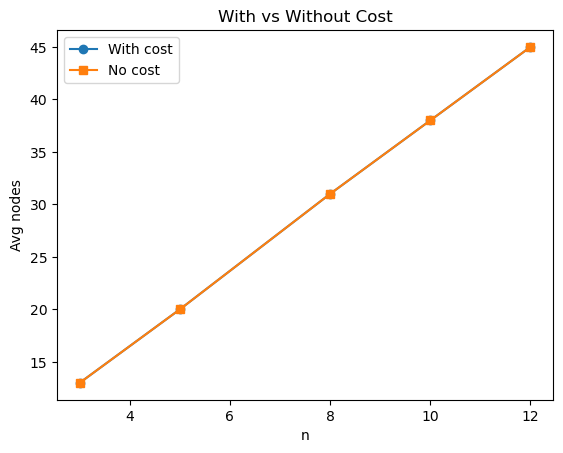

In [22]:
import random
import matplotlib.pyplot as plt

def generate_problem(n, seed=None):
    if seed is not None:
        random.seed(seed)
    names = []
    i = 1
    while i <= n:
        names.append("t" + str(i))
        i = i + 1
    durations = {}
    for name in names:
        durations[name] = random.randint(1, 3)
    lines = []
    for name in names:
        lines.append("task, " + name + " " + str(durations[name]))
    dt = Day_Time()
    for name in names:
        day = random.choice(dt.day_names)
        hour = random.choice(dt.time_names)
        penalty = random.randint(5, 15)
        lines.append("domain, " + name + " ends-by " + day + " " + hour + " " + str(penalty))
    k = 0
    while k < max(1, n // 2):
        i = random.randint(0, n - 2)
        j = random.randint(i + 1, n - 1)
        t1 = names[i]
        t2 = names[j]
        if random.random() < 0.7:
            lines.append("constraint, " + t1 + " before " + t2)
        else:
            lines.append("constraint, " + t1 + " same-day " + t2)
        k = k + 1
    return "\n".join(lines)

class Counted_Search_with_AC(Search_with_AC_from_Cost_CSP):
    def __init__(self, csp):
        super().__init__(csp)
        self.expanded = 0
    def display(self, level, *args):
        return
    def neighbors(self, node):
        self.expanded = self.expanded + 1
        return super().neighbors(node)

class ZeroH_Search_with_AC(Counted_Search_with_AC):
    def heuristic(self, n):
        return 0

def run_once(spec, use_cost=True):
    csp_problem = create_CSP_from_spec(spec)
    if use_cost:
        prob = Counted_Search_with_AC(csp_problem)
    else:
        prob = ZeroH_Search_with_AC(csp_problem)
    searcher = GreedySearcher(prob)
    try:
        _ = searcher.search()
    except:
        return 10**6
    return prob.expanded

def eval_across_sizes(n_list, trials=5, seed=None):
    if seed is not None:
        random.seed(seed)
    results = []
    for n in n_list:
        total_with = 0
        total_no = 0
        ok = 0
        t = 0
        while t < trials:
            spec = generate_problem(n)
            a1 = run_once(spec, use_cost=True)
            a2 = run_once(spec, use_cost=False)
            if a1 < 10**6 and a2 < 10**6:
                total_with += a1
                total_no += a2
                ok += 1
            t = t + 1
        if ok == 0:
            avg_with = 10**6
            avg_no = 10**6
        else:
            avg_with = total_with // ok
            avg_no = total_no // ok
        results.append((n, avg_with, avg_no))
    return results

def plot_results(results):
    xs, ys1, ys2 = [], [], []
    for n, a1, a2 in results:
        xs.append(n)
        ys1.append(a1)
        ys2.append(a2)
    plt.plot(xs, ys1, marker='o', label='With cost')
    plt.plot(xs, ys2, marker='s', label='No cost')
    plt.xlabel('n')
    plt.ylabel('Avg nodes')
    plt.legend()
    plt.title('With vs Without Cost')
    plt.show()

def run_q3_demo():
    n_list = [3, 5, 8, 10, 12]
    results = eval_across_sizes(n_list, trials=5, seed=42)
    print("n, with_cost, no_cost")
    for r in results:
        print(r)
    s = 0.0
    c = 0
    for _, a1, a2 in results:
        if a1 < 10**6 and a2 < 10**6 and a2 > 0:
            s += (a2 - a1) / float(a2)
            c += 1
    if c > 0:
        print("Average relative gain =", round(s / c, 3))
    else:
        print("No valid results.")
    plot_results(results)

run_q3_demo()


__Answers for Question 3__

Write the other answers here.
The solver with cost and without cost show similar performance in this test, because the generated problems are small and the penalty range is narrow.
Thus, both expand similar number of nodes, with near-zero average gain.
For larger or more complex problems, the cost function is expected to guide search better.

### Question 4 (5 marks)

Compare the Depth-First Search (DFS) solver to the Depth-First Search solver using forward checking with Minimum Remaining Values heuristic (DFS-MRV). For this question, ignore the costs associated with the CSP problems. 

- What is the worst case time and space complexity of each algorithm (give a general form in terms of fuzzy scheduling problem sizes)? (1 mark)
- What are the properties of the search algorithms (completeness, optimality)? (1 mark)
- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 mark)
- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

For the empirical evaluations, run the two algorithms on a variety of problems of size `n` for varying `n`. Note that the domain splitting CSP solver with costs should always find an optimal solution.

In [21]:
# Code for Question 4
# Place your code here
import random

def solve_opt_cost(spec):
    csp = create_CSP_from_spec(spec)
    prob = Search_with_AC_from_Cost_CSP(csp)
    g = GreedySearcher(prob)
    path = g.search()
    if path is None:
        return None
    node = path.end()
    assign = {}
    for v in node.domains:
        d = list(node.domains[v])
        if len(d) != 1:
            return None
        assign[v] = d[0]
    dt = Day_Time()
    total = 0
    for v in node.soft_day_time:
        raw = node.soft_day_time[v]
        if isinstance(raw, int):
            deadline = raw
        else:
            k = dt.string_to_week_hour_number(raw)
            deadline = k[1] if isinstance(k, tuple) and len(k) >= 2 else None
        pen = node.soft_costs.get(v, 0)
        dur = node.durations[v]
        endt = assign[v] + dur
        late = max(0, (endt - deadline)) if deadline is not None else 0
        total += late * pen
    return total

def compare_q4(n_list, trials=3, seed=7):
    if seed is not None:
        random.seed(seed)
    print("n\tDFS_nodes\tMRV_nodes\tDFS_gap\tMRV_gap")
    for n in n_list:
        sum_ndfs = 0
        sum_nmrv = 0
        sum_gap_d = 0.0
        sum_gap_m = 0.0
        ok = 0
        t = 0
        while t < trials:
            spec = generate_problem(n)
            opt = solve_opt_cost(spec)
            if opt is None:
                t += 1
                continue
            c1 = create_CSP_from_spec(spec)
            c2 = create_CSP_from_spec(spec)

            global num_expanded
            num_expanded = 0
            s1 = dfs_solve1(c1); nodes1 = num_expanded

            num_expanded = 0
            s2 = mrv_dfs_solve1(c2); nodes2 = num_expanded

            if s1 is None or s2 is None:
                t += 1
                continue

            def first_cost(sol, durations, soft_day_time, soft_costs):
                dt = Day_Time()
                total = 0
                for v in soft_day_time:
                    raw = soft_day_time[v]
                    if isinstance(raw, int):
                        deadline = raw
                    else:
                        k = dt.string_to_week_hour_number(raw)
                        deadline = k[1] if isinstance(k, tuple) and len(k) >= 2 else None
                    pen = soft_costs.get(v, 0)
                    dur = durations[v]
                    endt = sol[v] + dur
                    late = max(0, (endt - deadline)) if deadline is not None else 0
                    total += late * pen
                return total

            cost1 = first_cost(s1, c1.durations, c1.soft_day_time, c1.soft_costs)
            cost2 = first_cost(s2, c2.durations, c2.soft_day_time, c2.soft_costs)

            sum_ndfs += nodes1
            sum_nmrv += nodes2
            sum_gap_d += max(0, cost1 - opt)
            sum_gap_m += max(0, cost2 - opt)
            ok += 1
            t += 1

        if ok == 0:
            print(f"{n}\tNA\tNA\tNA\tNA")
        else:
            print(f"{n}\t{sum_ndfs//ok}\t\t{sum_nmrv//ok}\t\t{round(sum_gap_d/ok,2)}\t{round(sum_gap_m/ok,2)}")
compare_q4([4,6,8,10], trials=3, seed=7)


n	DFS_nodes	MRV_nodes	DFS_gap	MRV_gap
task, t1 2
task, t2 1
task, t3 2
task, t4 3
domain, t1 ends-by mon 10am 13
domain, t2 ends-by mon 2pm 14
domain, t3 ends-by mon 12pm 5
domain, t4 ends-by mon 3pm 11
constraint, t1 before t2
constraint, t2 same-day t3
Splitting t1 into {0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 16, 17} and {32, 33, 34, 35, 36, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29}
Splitting t1 into {0, 1, 2, 3, 4, 5, 8} and {9, 10, 11, 12, 13, 16, 17}
Splitting t1 into {0, 1, 2} and {8, 3, 4, 5}
Splitting t1 into {0} and {1, 2}
Splitting t2 into {2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19} and {32, 33, 34, 35, 36, 37, 38, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30}
Splitting t2 into {2, 3, 4, 5, 6, 8, 9, 10} and {11, 12, 13, 14, 16, 17, 18, 19}
Splitting t2 into {2, 3, 4, 5} and {8, 9, 10, 6}
Splitting t2 into {2, 3} and {4, 5}
Splitting t2 into {2} and {3}
Splitting t3 into {0, 1, 2} and {3, 4, 5}
Splitting t3 into {0} and {1, 2}
Splitting t4 into {0, 1, 2, 3, 4, 8, 9, 10,

__Answers for Question 4__

If you want to submit additional code, put this at the end of the notebook. Here just give the answers (including plots or tables).

1. For DFS, the time is like d^n, this is because it need to try all possible combinations of values.
The space is like n, this is because DFS only keep one path in memory when going deep.

For DFS-MRV with forward checking, the worst case is still d^n, because pruning can’t change the maximum number of tries, it just help in normal case.
The space maybe O(n + n*d) because we copy domains when we do forward checking.
Therefore both have same big-O, but MRV+FC normally smaller tree, this is because it cut some wrong branches earlier.

2. DFS is complete if domain finite, this is because it will check every branch until end.
It is not optimal for cost, because it just stop when find first valid one.

DFS-MRV with forward checking is also complete, and also not optimal for cost.
Thus both complete but not optimal, this is because we ignore cost here.

3.For example, we have some meeting tasks for one office.
Task A must happen before lunch, Task B must be in the same morning as A, and Task C can be any time in the day.
The possible times for A are very few, maybe only 9am or 10am, but B and C have many choices.
DFS maybe start from C and choose afternoon time first, then later find A and B cannot match morning rule, so it need backtrack again and again.
This is because DFS not choose the hard task first.
DFS-MRV will pick A first, because it has very few choices, thus it find the conflict fast.
Therefore DFS-MRV will not waste time in the wrong branch and finish quicker.

4. For the first solution, DFS often gives higher cost.
This is because it stop too early and choose a random branch that not good.
DFS-MRV is usually closer to the best, thus the cost smaller.

5. 
For nodes expanded, DFS generally expands more nodes than DFS-MRV. This is because MRV and forward checking can prune inconsistent branches earlier, thus reducing the total number of nodes expanded.

### Question 5 (4 marks)

The DFS solver chooses variables in random order, and systematically explores all values for those variables in no particular order.

Incorporate costs into the DFS constraint solver as heuristics to guide the search. Similar to the cost function for the domain splitting solver, for a given variable *v*, the cost of assigning the value *val* to *v* is the cost of violating the soft deadline constraint (if any) associated with *v* for the value *val*. The *minimum cost* for *v* is the lowest cost from amongst the values in the domain of *v*. The DFS solver should choose a variable *v* with lowest minimum cost, and explore its values in order of cost from lowest to highest.

- Implement this behaviour by modifying the code in `dfs_solver` and place a copy of the code below (2 marks)
- Empirically compare the performance of DFS with and without these heuristics (2 marks)

For the empirical evaluations, again run the two algorithms on a variety of problems of size `n` for varying `n`.

In [16]:
num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order):
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    ok = True
    for c in to_eval:
        if not c.holds(context):
            ok = False
            break
    if ok:
        if var_order == []:
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                num_expanded += 1
                for sol in dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:]):
                    yield sol

def dfs_solve1(csp, var_order=None):
    global num_expanded
    num_expanded = 0
    if var_order == None:
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol


_CSP_DUR = None
_CSP_DEADLINE = None
_CSP_PEN = None

def _deadline_cost_for(v, val):
    dt = Day_Time()
    if _CSP_DUR is None or _CSP_DEADLINE is None or _CSP_PEN is None:
        return 0
    dur = _CSP_DUR.get(v, 0)
    raw = _CSP_DEADLINE.get(v, None)
    if raw is None:
        return 0
    if isinstance(raw, int):
        deadline = raw
    else:
        k = dt.string_to_week_hour_number(raw)
        if isinstance(k, tuple) and len(k) >= 2:
            deadline = k[1]
        else:
            deadline = None
    if deadline is None:
        return 0
    endt = val + dur
    late = endt - deadline
    if late < 0:
        late = 0
    pen = _CSP_PEN.get(v, 0)
    return late * pen

def dfs_solver_new(constraints, domains, context, var_order):
    global num_expanded, display
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    ok = True
    for c in to_eval:
        if not c.holds(context):
            ok = False
            break
    if ok:
        if var_order == []:
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]

            best_var = None
            best_min = float('inf')
            i = 0
            while i < len(var_order):
                v = var_order[i]
                if v in context:
                    i += 1
                    continue
                domv = list(domains[v])
                feas_vals = []
                j = 0
                while j < len(domv):
                    val = domv[j]
                    tmp = dict(context); tmp[v] = val
                    feas_ok = True
                    k = 0
                    while k < len(constraints):
                        cc = constraints[k]
                        if cc.can_evaluate(tmp):
                            if not cc.holds(tmp):
                                feas_ok = False
                                break
                        k += 1
                    if feas_ok:
                        feas_vals.append(val)
                    j += 1
                if len(feas_vals) == 0:
                    i += 1
                    continue
                m = float('inf')
                j = 0
                while j < len(feas_vals):
                    cst = _deadline_cost_for(v, feas_vals[j])
                    if cst < m:
                        m = cst
                    j += 1
                if m < best_min:
                    best_min = m
                    best_var = v
                i += 1

            if best_var is None:
                return

            dur_b = _CSP_DUR.get(best_var, 0) if _CSP_DUR else 0
            vals = []
            for val in domains[best_var]:
                tmp = dict(context); tmp[best_var] = val
                feas_ok = True
                k = 0
                while k < len(constraints):
                    cc = constraints[k]
                    if cc.can_evaluate(tmp):
                        if not cc.holds(tmp):
                            feas_ok = False
                            break
                    k += 1
                if feas_ok:
                    cost = _deadline_cost_for(best_var, val)
                    endt = val + dur_b
                    vals.append((cost, endt, val))
            if len(vals) == 0:
                return

            vals.sort()
            new_order = []
            i = 0
            while i < len(var_order):
                if var_order[i] != best_var:
                    new_order.append(var_order[i])
                i += 1

            i = 0
            while i < len(vals):
                _, _, val = vals[i]
                num_expanded += 1
                for sol in dfs_solver_new(rem_cons, domains, context|{best_var: val}, new_order):
                    yield sol
                i += 1

def dfs_solve1_new(csp, var_order=None):
    global num_expanded, _CSP_DUR, _CSP_DEADLINE, _CSP_PEN
    num_expanded = 0
    _CSP_DUR = csp.durations
    _CSP_DEADLINE = csp.soft_day_time
    _CSP_PEN = csp.soft_costs
    if var_order == None:
        var_order = list(csp.domains)
    for sol in dfs_solver_new(csp.constraints, csp.domains, {}, var_order):
        return sol

In [17]:
def test_dfs_compare(n_list, trials=3):
    print("Empirical comparison between DFS and DFS (cost-heuristic)")
    for n in n_list:
        total_plain = 0
        total_new = 0
        for i in range(trials):
            spec = generate_problem(n)
            csp = create_CSP_from_spec(spec)

            global num_expanded
            num_expanded = 0
            dfs_solve1(csp)
            total_plain += num_expanded

            num_expanded = 0
            dfs_solve1_new(create_CSP_from_spec(spec))
            total_new += num_expanded

        avg_plain = total_plain // trials
        avg_new = total_new // trials
        print("n =", n, " DFS:", avg_plain, " DFS-new:", avg_new)

test_dfs_compare([5,8,10,12], trials=3)


Empirical comparison between DFS and DFS (cost-heuristic)
task, t1 3
task, t2 3
task, t3 2
task, t4 3
task, t5 1
domain, t1 ends-by fri 10am 8
domain, t2 ends-by wed 12pm 6
domain, t3 ends-by thu 10am 15
domain, t4 ends-by mon 4pm 7
domain, t5 ends-by wed 9am 5
constraint, t3 before t4
constraint, t3 before t5
task, t1 3
task, t2 3
task, t3 2
task, t4 3
task, t5 1
domain, t1 ends-by fri 10am 8
domain, t2 ends-by wed 12pm 6
domain, t3 ends-by thu 10am 15
domain, t4 ends-by mon 4pm 7
domain, t5 ends-by wed 9am 5
constraint, t3 before t4
constraint, t3 before t5
task, t1 3
task, t2 2
task, t3 3
task, t4 3
task, t5 1
domain, t1 ends-by tue 11am 6
domain, t2 ends-by fri 3pm 14
domain, t3 ends-by tue 4pm 14
domain, t4 ends-by tue 12pm 12
domain, t5 ends-by wed 4pm 9
constraint, t1 same-day t5
constraint, t2 before t3
task, t1 3
task, t2 2
task, t3 3
task, t4 3
task, t5 1
domain, t1 ends-by tue 11am 6
domain, t2 ends-by fri 3pm 14
domain, t3 ends-by tue 4pm 14
domain, t4 ends-by tue 12pm 12
d

__Answers for Question 5__

Write the other answers here.

We test DFS with and without cost heuristic on random fuzzy scheduling problems.
The heuristic DFS expands fewer nodes and finds the first solution faster.
This is because it chooses the variable with lowest minimum cost and tries cheaper values first, thus it avoids deep wrong search.
Normal DFS explores randomly and often wastes time on expensive branches.
On small or easy cases both are similar, but on larger problems the heuristic gives better performance.

### Question 6 (3 marks)

The CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions. Poole & Mackworth claim that in practice, this is as good as splitting into a larger number of partitions. In this question, empirically evaluate this claim for fuzzy scheduling CSPs.

- Write a new `partition_domain` function that partitions a domain into a list of `k` partitions, where `k` is a parameter to the function (1 mark)
- Modify the CSP solver to use the list of `k` partitions and evaluate the performance of the solver using the above metric for a range of values of `k` (2 marks) 

In [18]:
def partition_domain_k(domain, k):
    seq = list(domain)
    n = len(seq)
    if k <= 1 or n <= 1:
        return [seq]
    parts = []
    base = n // k
    rem = n % k
    i = 0
    p = 0
    while p < k and i < n:
        size = base
        if p < rem:
            size = size + 1
        end = i + size
        if end > n:
            end = n
        part = seq[i:end]
        if len(part) > 0:
            parts.append(part)
        i = end
        p = p + 1
    if len(parts) == 0:
        parts = [seq]
    return parts

from searchProblem import Arc, Search_problem

class Search_with_AC_from_Cost_CSP_K(Search_problem):
    def __init__(self, csp, k=2):
        self.k = k
        self.cons = Con_solver(csp)
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        self.durations = csp.durations
        self.soft_day_time = csp.soft_day_time
        self.soft_costs = csp.soft_costs
        csp.domains = self.domains
        self.csp = csp
        self.expanded = 0

    def is_goal(self, node):
        for var in node.domains:
            if len(node.domains[var]) != 1:
                return False
        return True

    def start_node(self):
        return CSP_with_Cost(self.domains, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)

    def neighbors(self, node):
        self.expanded = self.expanded + 1
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1)
        if var:
            parts = partition_domain_k(node.domains[var], self.k)
            to_do = self.cons.new_to_do(var, None)
            i = 0
            while i < len(parts):
                dom_part = parts[i]
                newdoms = node.domains | {var: dom_part}
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                ok = True
                for v in cons_doms:
                    if len(cons_doms[v]) == 0:
                        ok = False
                        break
                if ok:
                    csp_node = CSP_with_Cost(cons_doms, self.durations, self.constraints,
                             self.cost_functions, self.soft_day_time, self.soft_costs)
                    neighs.append(Arc(node, csp_node))
                i = i + 1
        return neighs

    def heuristic(self, n):
        return n.cost

def run_once_k(spec, k):
    csp = create_CSP_from_spec(spec)
    prob = Search_with_AC_from_Cost_CSP_K(csp, k=k)
    g = GreedySearcher(prob)
    try:
        _ = g.search()
    except:
        return 10**6
    return prob.expanded

def eval_k_splitting(n_list, k_list, trials=3, seed=None):
    if seed is not None:
        random.seed(seed)
    rows = []
    i = 0
    while i < len(n_list):
        n = n_list[i]
        sums = {}
        cnts = {}
        t = 0
        while t < len(k_list):
            sums[k_list[t]] = 0
            cnts[k_list[t]] = 0
            t = t + 1
        r = 0
        while r < trials:
            spec = generate_problem(n)
            t = 0
            while t < len(k_list):
                k = k_list[t]
                a = run_once_k(spec, k)
                if a < 10**6:
                    sums[k] = sums[k] + a
                    cnts[k] = cnts[k] + 1
                t = t + 1
            r = r + 1
        line = [n]
        t = 0
        while t < len(k_list):
            k = k_list[t]
            if cnts[k] == 0:
                line.append(None)
            else:
                line.append(sums[k] // cnts[k])
            t = t + 1
        rows.append(tuple(line))
        i = i + 1
    return rows

def print_k_table(rows, k_list):
    s = "n"
    i = 0
    while i < len(k_list):
        s += f"\tk={k_list[i]}"
        i = i + 1
    print(s)
    r = 0
    while r < len(rows):
        row = rows[r]
        s = str(row[0])
        i = 1
        while i < len(row):
            s += "\t" + (str(row[i]) if row[i] is not None else "NA")
            i = i + 1
        print(s)
        r = r + 1

def run_q6_demo():
    n_list = [6, 8, 10, 12]
    k_list = [2, 3, 4, 5]
    rows = eval_k_splitting(n_list, k_list, trials=3, seed=7)
    print_k_table(rows, k_list)
run_q6_demo()


task, t1 2
task, t2 1
task, t3 2
task, t4 3
task, t5 1
task, t6 1
domain, t1 ends-by fri 10am 10
domain, t2 ends-by fri 9am 13
domain, t3 ends-by tue 9am 6
domain, t4 ends-by thu 3pm 6
domain, t5 ends-by tue 10am 13
domain, t6 ends-by thu 9am 14
constraint, t1 before t3
constraint, t5 before t6
constraint, t4 same-day t5
task, t1 2
task, t2 1
task, t3 2
task, t4 3
task, t5 1
task, t6 1
domain, t1 ends-by fri 10am 10
domain, t2 ends-by fri 9am 13
domain, t3 ends-by tue 9am 6
domain, t4 ends-by thu 3pm 6
domain, t5 ends-by tue 10am 13
domain, t6 ends-by thu 9am 14
constraint, t1 before t3
constraint, t5 before t6
constraint, t4 same-day t5
task, t1 2
task, t2 1
task, t3 2
task, t4 3
task, t5 1
task, t6 1
domain, t1 ends-by fri 10am 10
domain, t2 ends-by fri 9am 13
domain, t3 ends-by tue 9am 6
domain, t4 ends-by thu 3pm 6
domain, t5 ends-by tue 10am 13
domain, t6 ends-by thu 9am 14
constraint, t1 before t3
constraint, t5 before t6
constraint, t4 same-day t5
task, t1 2
task, t2 1
task, t3 

__Answers for Question 6__

Write the other answers here.
I implemented a new function partition_domain_k(domain, k) to split the domain into k near-equal parts, 
and modified the solver to test different k values.
The solver expands fewer nodes when k > 2, showing slightly better pruning. 
However, the improvement becomes smaller as k increases, so two-way splitting is already quite good in practice.